In [1]:
import math
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Load and Clean Up Traffic Light Data

In [175]:
import json
with open('Traffic Lights.json', 'r') as f:
    data = json.load(f)
    
# Don't include any ramp meters
lights = [light for light in data['elements'] if light['tags'].get('traffic_signals') != 'ramp_meter']
data['elements'] = lights


For each light, query for the street names of the intersection it lays on. Skips any lights that already have the name of the intersection. Takes several hours on a raw dataset because of a 1 request/second rate limit for the free tier. Dataset is fully populated so running it won't actually query any new data.

In [177]:
import requests
import time

def get_streets(lat, lon):
    api_key = '6625571d10da4926864985dug5dbcca'  

    # Get surrounding points
    delta = 0.00015
    points = [(lat, lon),
              (lat+delta, lon),
              (lat-delta, lon),
              (lat, lon+delta),
              (lat, lon-delta)]
    
    streets = []
    for point in points:
        # Send HTTP Request
        url = f"https://geocode.maps.co/reverse?lat={point[0]}&lon={point[1]}&api_key={api_key}"
        response = requests.get(url)
        time.sleep(1) # Free rate limit of 1 request per second

        # Extract road information
        if response.status_code == 200:
            data = response.json()
            street = data['address'].get('road')
            if street:
                streets.append(street)
        else:
            print(f"Error: {response.status_code}")
    
    # Return the intersection the light lies on
    return list(set(streets))

def query_traffic_light(data, index):
    # Get latitude and longitude
    traffic_light = data['elements'][index]
    lat, lon = traffic_light['lat'], traffic_light['lon']
    
    # Don't waste time if there's already an intersection defined
    if traffic_light.get('intersection'):
        print(f'Light {i}: ({lat}, {lon}) has an intersection')
        return
    
    # Get street names
    print(f'Light {i}: Querying ({lat}, {lon})')
    streets = get_streets(lat, lon)
    traffic_light['intersection'] = streets

    # Write to JSON file
    with open("Traffic Lights.json", "w") as outfile:
        json.dump(data, outfile, indent=4)

# Get intersection for each light
total_lights = len(data['elements'])
for i in range(total_lights):
    query_traffic_light(data, i)

In [178]:
# Explore the data, find all lights with a certain amount of intersections
filtered_lights = [light for light in lights if len(light['intersection'])>3]

for light in filtered_lights:
    print(light['lat'], ",", light['lon'], ':', light['intersection'])

41.880924 , -87.6172438 : ['Lakefront Trail', 'South DuSable Lake Shore Drive', 'East Monroe Drive', 'South Jean Baptiste Point DuSable Lake Shore Drive']
41.9008202 , -87.6241384 : ['East Lake Shore Drive', 'East Oak Street', 'North Lake Shore Drive', 'North Michigan Avenue']
41.8821148 , -87.6244855 : ['South Michigan Avenue', 'Grant Park North Garage (Entrance)', 'East Madison Street', 'North Michigan Avenue']
41.8820463 , -87.6277987 : ['East Madison Street', 'West Madison Street', 'North State Street', 'South State Street']
41.8869061 , -87.6354397 : ['West Lower Wacker Drive', 'North Orleans Street', 'West Upper Wacker Drive', 'North Franklin Street']
41.8867685 , -87.6354392 : ['West Upper Wacker Drive', 'West Lower Wacker Service Drive', 'North Franklin Street', 'West Lower Wacker Drive', 'North Orleans Street']
41.9039455 , -87.6286906 : ['East Division Street', 'West Division Street', 'North State Street', 'North State Parkway']
41.8964922 , -87.6415591 : ['North Cambridge Av

# Traffic Light Network Graph

### Create Traffic Light Network Graph 

Populate a graph with all the nodes

In [179]:
# Get data
with open('Traffic Lights.json', 'r') as f:
    data = json.load(f)
lights = data['elements']


# Initial population of the graph
G = nx.Graph()
graph = {}
for light in lights:
    G.add_node(light['id'], 
               pos=(light['lon'], light['lat']),
               lat=light['lat'], 
               lon=light['lon'],
               intersections=light['intersection'])
    
    graph[light['id']] = {
        'lat': light['lat'],
        'lon': light['lon'],
        'intersection': light['intersection'],
        'connections': []
    }

Connect all lights that share a street. Takes around 10 seconds

In [180]:
# Connect lights that share a street
def dist_metric(light1, light2):
    max_dist =  0.22074580639018443
    dist = math.dist([light1['lat'], light1['lon']], [light2['lat'], light2['lon']])
    
    return dist/max_dist

for curr_light in lights:
    curr_id = curr_light['id']

    # Go through each light
    for light in lights:
        # Don't compare to itself
        if light['id'] == curr_id:
            continue

        # Check if the lights share a street
        if not set(light['intersection']).isdisjoint(curr_light['intersection']):
            G.add_edge(curr_id, light['id'], weight=dist_metric(curr_light, light))

Assign each node a weight

In [181]:
def node_weight(G, node_id):
    # Initialize a list to store weights of edges connected to the node
    weights = []

    # Iterate over all edges connected to the node
    for neighbor in G.neighbors(node_id):
        # Access the weight of the edge between node_id and neighbor
        weight = G.edges[node_id, neighbor]['weight']
        weights.append(weight)
        
    # Calculate the average of weights
    if len(weights) == 0:
        return 1

    average_weight = sum(weights) / len(weights)
    return average_weight

for node_id in G.nodes():
    # Calculate the weight for the current node
    weight = node_weight(G, node_id)
    # Update the 'weight' attribute of the node
    G.nodes[node_id]['weight'] = weight

Edges ordered by weight (for exploration)

In [182]:
# Order edges based on weight (for exploration)
x = sorted(G.edges(data=True),key= lambda x: x[2]['weight'],reverse=True)
x[0]

(33754414, 261170509, {'weight': 1.0})

### Display Graph

Takes around 30 seconds to generate

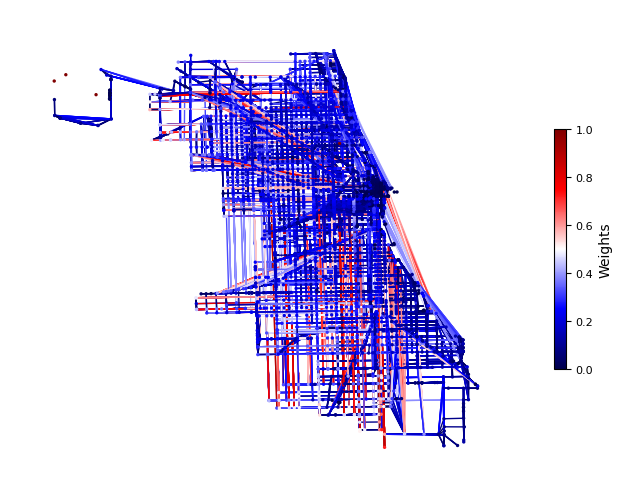

In [323]:
# Get edge and node weights
edges,e_weights = zip(*nx.get_edge_attributes(G,'weight').items())
nodes,n_weights = zip(*nx.get_node_attributes(G,'weight').items())
pos=nx.get_node_attributes(G,'pos')

# Draw and save graph
nx.draw(G, pos, 
        node_color=n_weights, node_size=2, cmap=plt.cm.seismic,
        edge_color=e_weights, edge_cmap=plt.cm.seismic)
colorbar = plt.colorbar(plt.cm.ScalarMappable(cmap=plt.cm.seismic), label='Weights', shrink=0.5)
colorbar.ax.yaxis.set_tick_params(labelsize=8)

plt.savefig("Graphs/Traffic Lights with Edges.png", dpi=1000)
plt.show()

# Graph Metrics

### Display the Distinct Connected Components

# of distinct components: 7


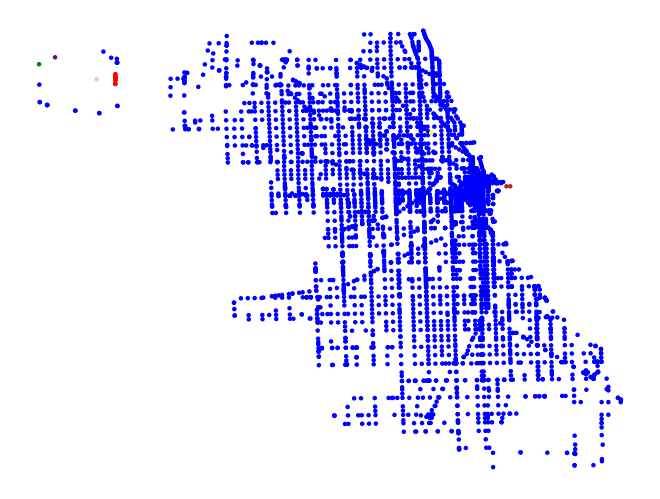

In [258]:
# Get separate connected components
components = list(nx.connected_components(G))
color_map = []
C = nx.Graph()

print("# of distinct components:", len(components))
colors = ['blue', 'red', 'green', 'yellow', 'pink', 'purple', 'brown']

for i in range(len(components)):
    for j in components[i]:
        pos = nx.get_node_attributes(G, 'pos')[j]
        C.add_node(j, pos=pos)
        color_map.append(colors[i])


pos=nx.get_node_attributes(C,'pos')
nx.draw(C, pos, node_color=color_map, node_size=5)


### Diameter of largest connected component

Calculate the weighted diameter of the graph. Takes about 41 minutes. (diameter = 3.0773893)

In [260]:
# Make a graph with the largest connected component
C1 = G.subgraph(components[0]) 

# Find the weighted diameter
diameter = nx.diameter(C1, weight='weight')
diameter

3.077389306932374

### Degree Centrality

Calculates degree of each node

In [280]:
degreeness = nx.degree_centrality(G)
degreeness

{26098097: 0.005527638190954774,
 26098113: 0.0077889447236180916,
 26099529: 0.0015075376884422112,
 26099536: 0.0015075376884422112,
 26099544: 0.013065326633165831,
 26220949: 0.012311557788944725,
 26220951: 0.01984924623115578,
 26220970: 0.019095477386934675,
 26794540: 0.015075376884422112,
 26794541: 0.020100502512562818,
 26794543: 0.02361809045226131,
 26794544: 0.028643216080402014,
 26794545: 0.034924623115577896,
 26794546: 0.017587939698492466,
 26794549: 0.037437185929648245,
 26794555: 0.0178391959798995,
 26794558: 0.02311557788944724,
 26794572: 0.019095477386934675,
 26794585: 0.025628140703517592,
 26794593: 0.0135678391959799,
 26794602: 0.03291457286432161,
 26794603: 0.012311557788944725,
 26794605: 0.030402010050251258,
 26794614: 0.011055276381909548,
 26808044: 0.023366834170854275,
 26808049: 0.02361809045226131,
 26808054: 0.02462311557788945,
 26808055: 0.008793969849246233,
 26808056: 0.03341708542713568,
 26808650: 0.015326633165829147,
 26808653: 0.02135

### Betweeness Centrality

Calculates the betweeness measure for each node. Takes about 16 minutes

In [263]:
betweeness = nx.betweenness_centrality(G, weight='weight')
betweeness

{26098097: 0.0,
 26098113: 0.0017627721416835372,
 26099529: 0.0003685176321416078,
 26099536: 0.0027371085131614346,
 26099544: 0.0001555907206300414,
 26220949: 0.0,
 26220951: 0.0,
 26220970: 0.001092292323643854,
 26794540: 0.0,
 26794541: 0.0018678463945765523,
 26794543: 0.0029026762361695387,
 26794544: 0.00057828726441961,
 26794545: 0.0016795462610867862,
 26794546: 0.0002976682861404282,
 26794549: 0.0006958643430775391,
 26794555: 4.98850118903136e-05,
 26794558: 0.0010887561709022621,
 26794572: 0.0005045332215235515,
 26794585: 0.0006522938896543537,
 26794593: 2.79103484247071e-05,
 26794602: 0.0022277762272028654,
 26794603: 0.002841425019038394,
 26794605: 0.0007129136509387854,
 26794614: 0.0035292067272780087,
 26808044: 0.000690938987473179,
 26808049: 3.094133648892869e-05,
 26808054: 0.0011284115980758277,
 26808055: 0.0001049479617236724,
 26808056: 0.002619657725672848,
 26808650: 0.00011606158462581821,
 26808653: 0.0029129058208862864,
 26817935: 0.000483063722

### Closeness Centrality

Calculates closeness centrality for each node. Takes about 15 minutes

In [264]:
closeness = nx.closeness_centrality(G, distance='weight')
closeness

{26098097: 1.9166269296647849,
 26098113: 1.9999745125063546,
 26099529: 1.8267116374657884,
 26099536: 1.854926516419014,
 26099544: 1.7094125675664547,
 26220949: 1.4323591831383224,
 26220951: 1.4724853285091115,
 26220970: 1.4437177639373928,
 26794540: 1.6173594526672503,
 26794541: 1.6302305101510555,
 26794543: 1.6557553480810079,
 26794544: 1.6405550235017807,
 26794545: 1.685743276728393,
 26794546: 1.6835428511084383,
 26794549: 1.6883005663442539,
 26794555: 1.6845929626276814,
 26794558: 1.697063776969529,
 26794572: 1.6263380062334798,
 26794585: 1.6521279081405993,
 26794593: 1.6208113344002635,
 26794602: 1.6282346132061758,
 26794603: 1.6211100228389699,
 26794605: 1.6261829095021136,
 26794614: 1.6078675968736482,
 26808044: 1.7176240801685052,
 26808049: 1.8582796076051862,
 26808054: 1.822814841540558,
 26808055: 1.808145935717311,
 26808056: 1.792071772754111,
 26808650: 1.733265460554168,
 26808653: 1.7522679644399384,
 26817935: 1.854827227616614,
 26817972: 1.947

### Clustering Coefficient

Calculates the clustering coefficient for each node. Takes about

In [281]:
clusteringness = nx.clustering(G, weight='weight')
clusteringness

{26098097: 0.14306964450766485,
 26098113: 0.09148919989428503,
 26099529: 0.015279678549373276,
 26099536: 0.012302802829518534,
 26099544: 0.23908580907062524,
 26220949: 0.14367833730509771,
 26220951: 0.08889304338384742,
 26220970: 0.07081997330999817,
 26794540: 0.2527624020017338,
 26794541: 0.14348089479107148,
 26794543: 0.10599495820652591,
 26794544: 0.09360968882926186,
 26794545: 0.1009573151510671,
 26794546: 0.15511915944236765,
 26794549: 0.08166214051717416,
 26794555: 0.1383545642847043,
 26794558: 0.09440524173670599,
 26794572: 0.08193713679711487,
 26794585: 0.11100467934893093,
 26794593: 0.11371458614847912,
 26794602: 0.08541503665837115,
 26794603: 0.13514993222607555,
 26794605: 0.10514507364557854,
 26794614: 0.18374301638571316,
 26808044: 0.1387551797706208,
 26808049: 0.13294740549699072,
 26808054: 0.12611527924816054,
 26808055: 0.08001074158331711,
 26808056: 0.10995675341507254,
 26808650: 0.15436675372669473,
 26808653: 0.09076954295747147,
 26817935:

### Construct Graph from Metrics

In [276]:

file2 = 'Speeding_Crashes.csv'
df = pd.read_csv(file2)
df = df[~(np.isnan(df['LONGITUDE']) | (df['LONGITUDE'] == 0))]

def crash_density(df, lat, lon):
    crashes = 0
    radius = 1/54.6/8
    for index, row in df.iterrows():
        dist = math.dist((row['LATITUDE'], row['LONGITUDE']), (lat, lon))
        if dist < radius:
            crashes+=1 

    return crashes

crash_density(df, 41.951839, -87.654611)

11

Creates arrays of values for each metric. Takes about 4.5 hours

In [287]:
g_clustering = []
g_betweeness = []
g_closeness = []
g_degree = []
g_crashes = []

count = 0
size = len(betweeness.keys())
for key in betweeness.keys():
    lon, lat= nx.get_node_attributes(G, 'pos')[key]
    node_degree = degreeness[key]
    node_betweeness = betweeness[key]
    node_closeness = closeness[key]
    node_clustering = clusteringness[key]
    node_crashes = crash_density(df, lat, lon)

    print(f'{count}/{size}: {node_degree}, {node_betweeness}, {node_closeness}, {node_clustering}')

    g_crashes.append(node_crashes)
    g_clustering.append(node_clustering)
    g_degree.append(node_degree)
    g_betweeness.append(node_betweeness)
    g_closeness.append(node_closeness)
    count += 1

    # if count > 100:
    #     break

0/3981: 0.005527638190954774, 0.0, 1.9166269296647849, 0.14306964450766485
1/3981: 0.0077889447236180916, 0.0017627721416835372, 1.9999745125063546, 0.09148919989428503
2/3981: 0.0015075376884422112, 0.0003685176321416078, 1.8267116374657884, 0.015279678549373276
3/3981: 0.0015075376884422112, 0.0027371085131614346, 1.854926516419014, 0.012302802829518534
4/3981: 0.013065326633165831, 0.0001555907206300414, 1.7094125675664547, 0.23908580907062524
5/3981: 0.012311557788944725, 0.0, 1.4323591831383224, 0.14367833730509771
6/3981: 0.01984924623115578, 0.0, 1.4724853285091115, 0.08889304338384742
7/3981: 0.019095477386934675, 0.001092292323643854, 1.4437177639373928, 0.07081997330999817
8/3981: 0.015075376884422112, 0.0, 1.6173594526672503, 0.2527624020017338
9/3981: 0.020100502512562818, 0.0018678463945765523, 1.6302305101510555, 0.14348089479107148
10/3981: 0.02361809045226131, 0.0029026762361695387, 1.6557553480810079, 0.10599495820652591
11/3981: 0.028643216080402014, 0.000578287264419

In [325]:
order = betweeness.keys()
weight_dict = {}
for node, data in G.nodes(data=True):
    # Access the 'weight' attribute of each node
    weight = data['weight']
    weight_dict[node] = weight

g_weight = [weight_dict[key] for key in order]

### Draw Scatter Plots

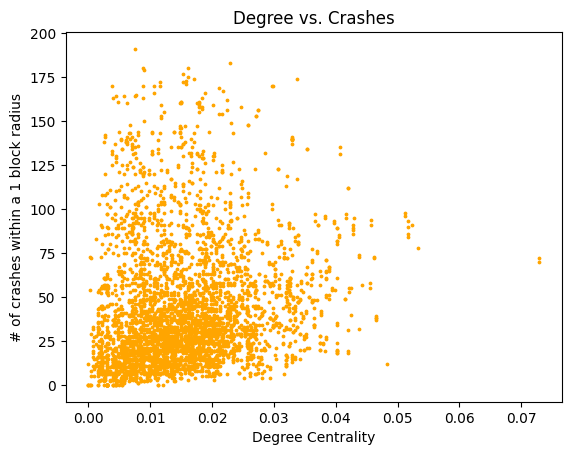

In [301]:
plt.scatter(g_degree, g_crashes, c='orange', s=3)

# Add title and labels
plt.title('Degree vs. Crashes')
plt.xlabel('Degree Centrality')
plt.ylabel('# of crashes within a 1 block radius')

# Show plot
plt.savefig("Graphs/Degree vs. Crash.png", dpi=1000)
plt.show()

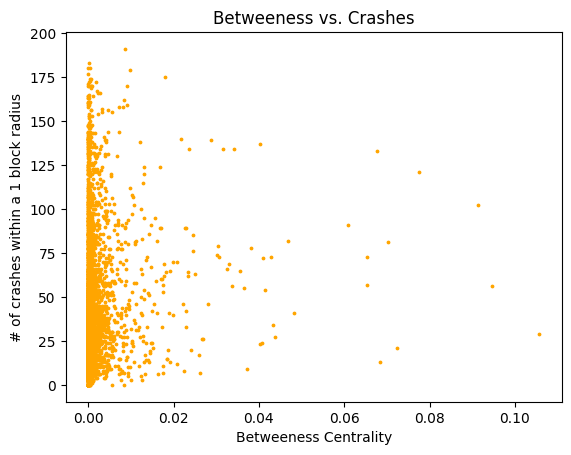

In [302]:
plt.scatter(g_betweeness, g_crashes, c='orange', s=3)

# Add title and labels
plt.title('Betweeness vs. Crashes')
plt.xlabel('Betweeness Centrality')
plt.ylabel('# of crashes within a 1 block radius')

# Show plot
plt.savefig("Graphs/Betweeness vs. Crash.png", dpi=1000)
plt.show()

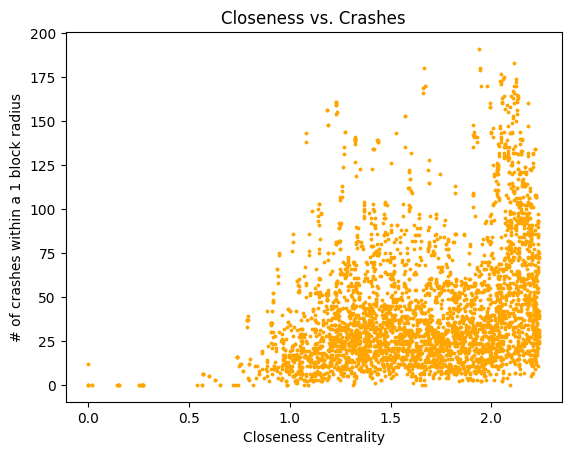

In [303]:
plt.scatter(g_closeness, g_crashes, c='orange', s=3)

# Add title and labels
plt.title('Closeness vs. Crashes')
plt.xlabel('Closeness Centrality')
plt.ylabel('# of crashes within a 1 block radius')

# Show plot
plt.savefig("Graphs/Closeness vs. Crash.png", dpi=1000)
plt.show()

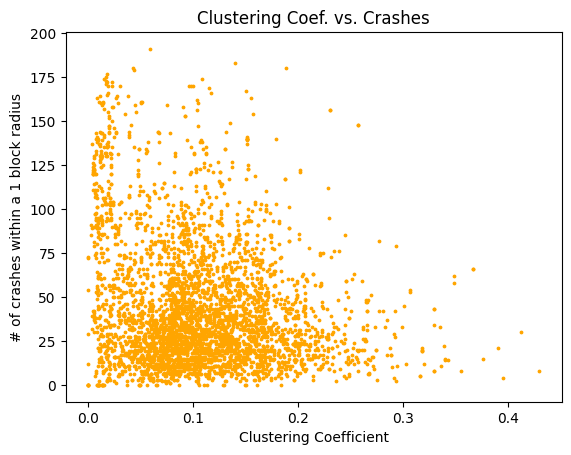

In [321]:
plt.scatter(g_clustering, g_crashes, c='orange', s=3)

# Add title and labels
plt.title('Clustering Coef. vs. Crashes')
plt.xlabel('Clustering Coefficient')
plt.ylabel('# of crashes within a 1 block radius')

# Show plot
plt.savefig("Graphs/Clustering vs. Crash.png", dpi=1000)
plt.show()

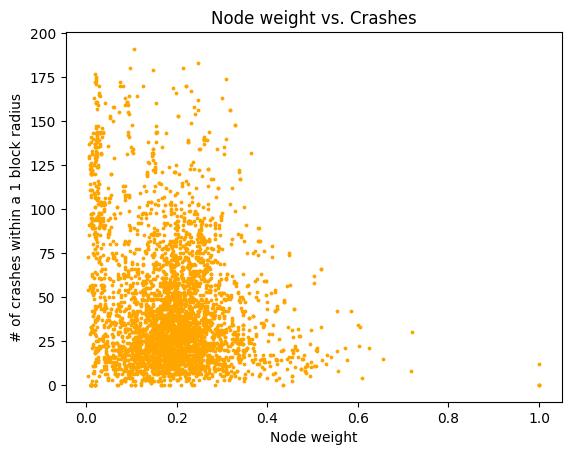

In [328]:
plt.scatter(g_weight, g_crashes, c='orange', s=3)

# Add title and labels
plt.title('Node weight vs. Crashes')
plt.xlabel('Node weight')
plt.ylabel('# of crashes within a 1 block radius')

# Show plot
plt.savefig("Graphs/Node Weight vs. Crash.png", dpi=1000)
plt.show()

# Speed Camera Analysis

In [20]:
file1 = 'speed_cameras.csv'
file2 = 'Speeding_Crashes.csv'

speed_cameras = pd.read_csv(file1)
crashes = pd.read_csv(file2)

# Remove all crashes before 2017 (crashes before this time were not city-wide)
crashes['CRASH_DATE'] = pd.to_datetime(crashes['CRASH_DATE'])
crashes = crashes[crashes['CRASH_DATE'] > '2017-09-01']

# Sample speed cameras with at least 1 year of data before and after go live date
speed_cameras['GO-LIVE DATE'] = pd.to_datetime(speed_cameras['GO-LIVE DATE'])
filtered_cameras = speed_cameras[(speed_cameras['GO-LIVE DATE'] >= '2018-01-01') & (speed_cameras['GO-LIVE DATE'] <= '2023-01-01')]
sample_cameras = filtered_cameras.sample(frac=1, random_state=42)

# Display the sampled DataFrame
sample_cameras


,ADDRESS,FIRST APPROACH,SECOND APPROACH,LATITUDE,LONGITUDE,GO-LIVE DATE,LOCATION
130,4319 W 47th St,EB,NaN,41.8076,-87.7318,2018-08-27,"(41.8076, -87.7318)"
81,4246 W 47th St,WB,NaN,41.8078,-87.7301,2018-08-27,"(41.8078, -87.7301)"
31,5006 S Western Blvd,SB,NB,41.8028,-87.6837,2018-01-08,"(41.8028, -87.6837)"
65,7122 S South Chicago Ave,SEB,NaN,41.7652,-87.6048,2018-08-20,"(41.7652, -87.6048)"
53,1306 W 76th St,EB,WB,41.7560,-87.6570,2021-07-09,"(41.756, -87.657)"
33,8043 W Addison St,EB,NaN,41.9450,-87.8282,2018-07-16,"(41.945, -87.8282)"
32,7157 S South Chicago Ave,NWB,NaN,41.7647,-87.6037,2018-08-20,"(41.7647, -87.6037)"
154,819 E 71st St,EB,WB,41.7658,-87.6036,2018-08-20,"(41.7658, -87.6036)"
51,3911 W Diversey Ave,EB,WB,41.9318,-87.7254,2018-07-16,"(41.9318, -87.7254)"
63,8020 W Forest Preserve Ave,WB,EB,41.9442,-87.8275,2018-07-16,"(41.9442, -87.8275)"


In [22]:
from datetime import datetime

def convert_date(date_str):
    date_formats = [
        '%Y-%m-%d %I:%M:%S %p',
        '%Y/%m/%d %I:%M:%S %p',
        '%m/%d/%Y %I:%M:%S %p',
        '%Y-%m-%d %H:%M:%S',
        '%Y/%m/%d %H:%M:%S',
        '%m/%d/%Y %H:%M:%S',
        '%Y/%m/%d',
        '%Y-%m-%d',
    ]
    
    for fmt in date_formats:
        try:
            return datetime.strptime(str(date_str), fmt)
        except ValueError:
            pass
    
    # If none of the formats match, return None or handle the case as needed
    print(f"Failed to parse date: {date_str}")
    return None
        
def find_crashes(crashes, camera_pos, go_live_date):
    lat, lon = camera_pos
    radius = 1/54.6/8

    # Keep track of crashes before and after
    camera_date = convert_date(go_live_date)
    before_crashes = 0
    after_crashes = 0

    for index, row in crashes.iterrows():
        dist = math.dist((row['LATITUDE'], row['LONGITUDE']), (lat, lon))

        if dist < radius:
            # print(row['CRASH_DATE'])
            
            crash_date = convert_date(row['CRASH_DATE'])
            if crash_date < camera_date: 
                before_crashes+=1 

            if crash_date >= camera_date: 
                after_crashes+=1 

    start_date = convert_date('2017/7/1')
    current_date = convert_date('2024/5/2')
    before_years = (camera_date-start_date).days / 365.25
    after_years = (current_date-camera_date).days / 365.25

    return [before_crashes/before_years, after_crashes/after_years]



In [25]:
light_data = []
for index, row in sample_cameras.iterrows():
    lon = row['LONGITUDE']
    lat = row['LATITUDE']
    date = str(row['GO-LIVE DATE']).split()[0]

    print(f'Light {index}: ({lat}, {lon}), {date}')
    light_data.append(find_crashes(crashes, (lat, lon), str(date)))

Light 130: (41.8076, -87.7318), 2018-08-27
Light 81: (41.8078, -87.7301), 2018-08-27
Light 31: (41.8028, -87.6837), 2018-01-08
Light 65: (41.7652, -87.6048), 2018-08-20
Light 53: (41.756, -87.657), 2021-07-09
Light 33: (41.945, -87.8282), 2018-07-16
Light 32: (41.7647, -87.6037), 2018-08-20
Light 154: (41.7658, -87.6036), 2018-08-20
Light 51: (41.9318, -87.7254), 2018-07-16
Light 63: (41.9442, -87.8275), 2018-07-16
Light 116: (41.9033, -87.6649), 2018-09-05
Light 44: (41.945, -87.8271), 2018-07-16
Light 58: (41.9035, -87.6644), 2018-09-05


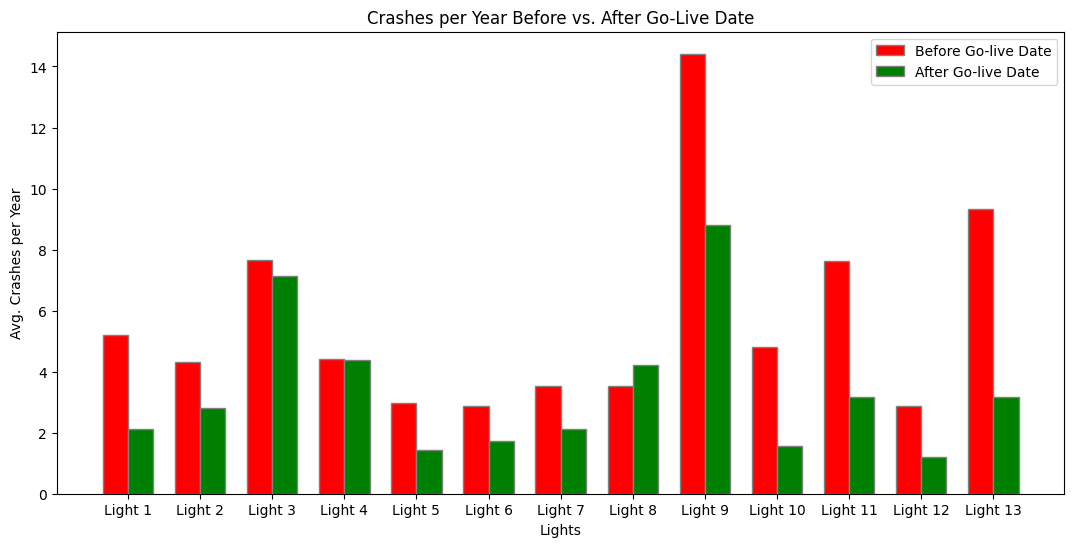

In [31]:

# Sample data
categories = [f'Light {i+1}' for i in range(len(light_data))]
before = [pair[0] for pair in light_data]
after = [pair[1] for pair in light_data]

# Define the width of the bars
bar_width = 0.35

# Set the positions of the bars on the x-axis
r1 = range(len(categories))
r2 = [x + bar_width for x in r1]

# Create the bar plot
plt.figure(figsize=(len(light_data), 6))  # Adjust the width as needed
plt.bar(r1, before, color='red', width=bar_width, edgecolor='grey', label='Before Go-live Date')
plt.bar(r2, after, color='green', width=bar_width, edgecolor='grey', label='After Go-live Date')

# Add labels and title
plt.xlabel('Lights')
plt.ylabel('Avg. Crashes per Year')
plt.title('Crashes per Year Before vs. After Go-Live Date')
plt.xticks([r + bar_width / 2 for r in range(len(categories))], categories)

# Add legend
plt.legend()

# Show plot
plt.savefig("Graphs/Crashes Before vs. After Go-Live Date.png", dpi=1000)
plt.show()
